# Forest Fires - Regression

Predicting the size of forest fires based on meteorological data https://archive.ics.uci.edu/ml/datasets/Forest+Fires

The file is in ``../data/forestfires.csv``

* Read the data into a DataFrame
* Examine the types
* Describe the data

Attribute information:

   For more information, read [Cortez and Morais, 2007].

   1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
   2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
   3. month - month of the year: "jan" to "dec" 
   4. day - day of the week: "mon" to "sun"
   5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
   6. DMC - DMC index from the FWI system: 1.1 to 291.3 
   7. DC - DC index from the FWI system: 7.9 to 860.6 
   8. ISI - ISI index from the FWI system: 0.0 to 56.10
   9. temp - temperature in Celsius degrees: 2.2 to 33.30
   10. RH - relative humidity in %: 15.0 to 100
   11. wind - wind speed in km/h: 0.40 to 9.40 
   12. rain - outside rain in mm/m2 : 0.0 to 6.4 
   13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
   (this output variable is very skewed towards 0.0, thus it may make
    sense to model with the logarithm transform).




In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns

In [86]:
from sklearn.model_selection import GridSearchCV , StratifiedKFold, train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,PassiveAggressiveClassifier
from sklearn.linear_model import ElasticNet

## Exercise: Load data

We will use a row of data for input. We will call the input X and the prediction y. This is called "supervised learning" as we will feed in both X and y to train the model.

This performs better if we *standardize* the data.

Predict the the size of forest fires from the other columns.


In [36]:
!wget https://github.com/Dinesh-Adhithya-H/Advanced-Programming-in-Python/raw/main/Forest-Fires-Prediction/forestfires.csv

--2021-11-16 16:31:50--  https://github.com/Dinesh-Adhithya-H/Advanced-Programming-in-Python/raw/main/Forest-Fires-Prediction/forestfires.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dinesh-Adhithya-H/Advanced-Programming-in-Python/main/Forest-Fires-Prediction/forestfires.csv [following]
--2021-11-16 16:31:50--  https://raw.githubusercontent.com/Dinesh-Adhithya-H/Advanced-Programming-in-Python/main/Forest-Fires-Prediction/forestfires.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25478 (25K) [text/plain]
Saving to: ‘forestfires.csv.1’

forestfires.csv.1   100%[===================

In [37]:
df_ff = pd.read_csv('forestfires.csv')

In [38]:
df_ff.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [39]:
df_ff.isna().all()

X        False
Y        False
month    False
day      False
FFMC     False
DMC      False
DC       False
ISI      False
temp     False
RH       False
wind     False
rain     False
area     False
dtype: bool

# Data Exploration

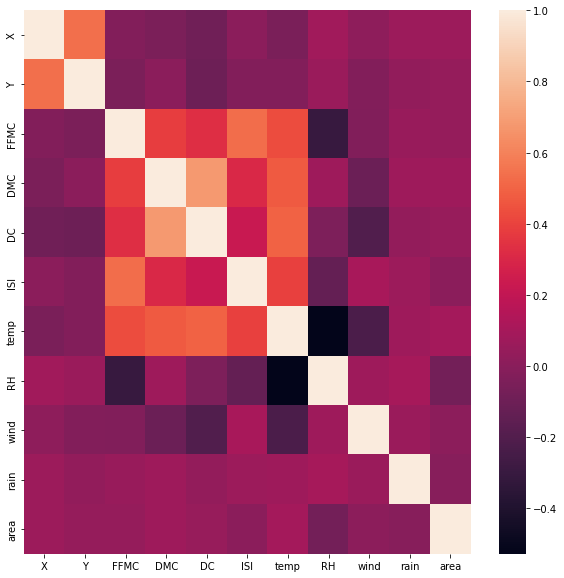

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(df_ff.corr())

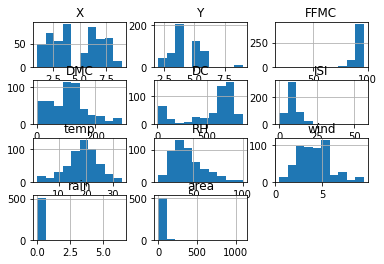

In [8]:
df_ff.hist()
plt.show()

Text(0, 0.5, 'Cummulative burned area of forest fires')

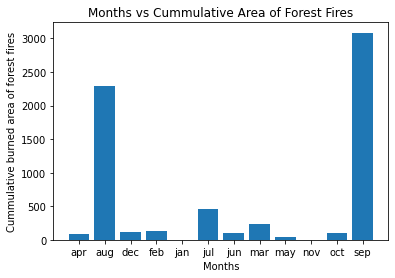

In [9]:
df_month=df_ff.groupby("month").sum()
plt.bar(df_month.index,df_month["area"])
plt.title("Months vs Cummulative Area of Forest Fires")
plt.xlabel("Months")
plt.ylabel("Cummulative burned area of forest fires")

Text(0, 0.5, 'Average burned area of forest fires')

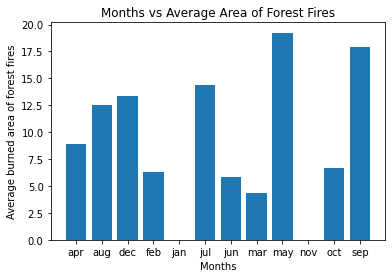

In [10]:
df_month=df_ff.groupby("month").mean()
plt.bar(df_month.index,df_month["area"])
plt.title("Months vs Average Area of Forest Fires")
plt.xlabel("Months")
plt.ylabel("Average burned area of forest fires")

Text(0, 0.5, 'Cummulative burned area of forest fires')

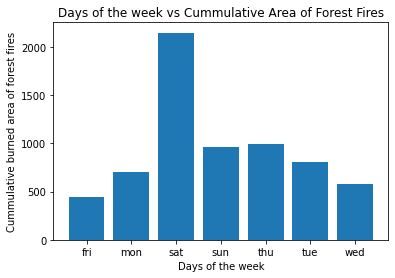

In [11]:
df_day=df_ff.groupby("day").sum()
plt.bar(df_day.index,df_day["area"])
plt.title("Days of the week vs Cummulative Area of Forest Fires")
plt.xlabel("Days of the week")
plt.ylabel("Cummulative burned area of forest fires")

Text(0, 0.5, 'Average burned area of forest fires')

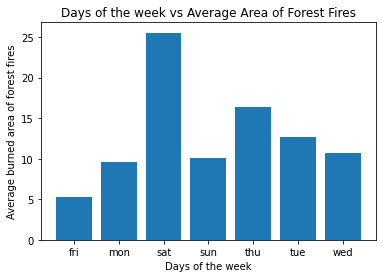

In [12]:
df_day=df_ff.groupby("day").mean()
plt.bar(df_day.index,df_day["area"])
plt.title("Days of the week vs Average Area of Forest Fires")
plt.xlabel("Days of the week")
plt.ylabel("Average burned area of forest fires")

In [40]:
months=np.array(df_ff["month"])
days=np.array(df_ff["day"])

In [41]:
df_ff.drop(["month","day"],axis=1,inplace=True)

In [42]:
columns=df_ff.columns

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [44]:
y=df_ff["area"]
df_ff.drop("area",axis=1,inplace=True)

In [45]:
y

0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
       ...  
512     6.44
513    54.29
514    11.16
515     0.00
516     0.00
Name: area, Length: 517, dtype: float64

In [46]:
scaler = StandardScaler()
data=scaler.fit_transform(np.array(df_ff))

In [63]:
#df_ff=pd.DataFrame(data,columns=columns)

In [48]:
df_ff

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0
...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0


In [49]:
enc=OneHotEncoder()
month=enc.fit_transform(months.reshape(-1,1)).toarray()
month_names=enc.get_feature_names()
for i in range(len(month_names)):
  df_ff[month_names[i]]=month[:,i]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [50]:
enc=OneHotEncoder()
day=enc.fit_transform(days.reshape(-1,1)).toarray()
day_names=enc.get_feature_names()
for i in range(len(day_names)):
  df_ff[day_names[i]]=day[:,i]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [52]:
df_ff

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,x0_apr,x0_aug,x0_dec,x0_feb,x0_jan,x0_jul,x0_jun,x0_mar,x0_may,x0_nov,x0_oct,x0_sep,x0_fri,x0_mon,x0_sat,x0_sun,x0_thu,x0_tue,x0_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [53]:
x_train,x_test,y_train,y_test=train_test_split(x,y)

# Machine Learning

In [54]:
lr=LinearRegression().fit(x_train,y_train)
r=Ridge().fit(x_train,y_train)

In [55]:
np.mean((lr.predict(x_test)-y_test)**2)

844.9615799504743

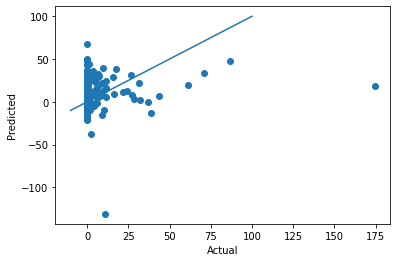

In [61]:
plt.scatter(y_test,lr.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

In [91]:
np.mean((r.predict(x_test)-y_test)**2)

814.546261042613

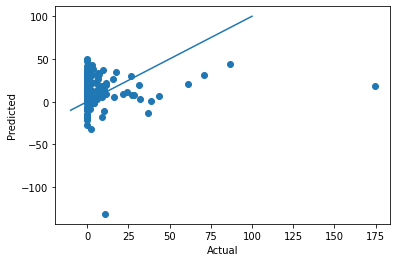

In [62]:
plt.scatter(y_test,r.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

In [79]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(13, 10), random_state=1,activation='logistic',max_iter=1000).fit(x_train,y_train)

In [80]:
np.mean((clf.predict(x_test)-y_test)**2)

969.8046208572342

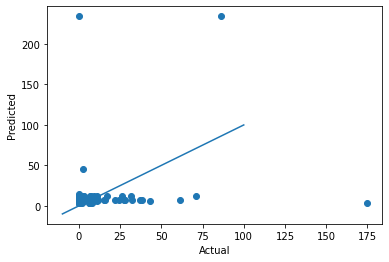

In [81]:
plt.scatter(y_test,clf.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

RMSE :  1059.5042708317085


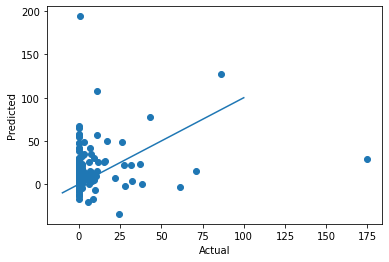

In [85]:
clf=LGBMRegressor().fit(x_train,y_train)
print("RMSE : ",np.mean((clf.predict(x_test)-y_test)**2))
plt.scatter(y_test,clf.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

[16:49:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  880.7911558898409


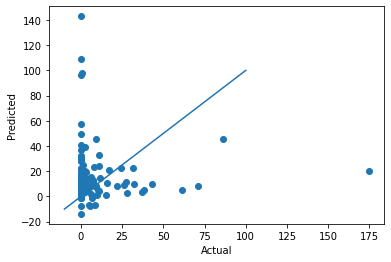

In [87]:
clf=XGBRegressor().fit(x_train,y_train)
print("RMSE : ",np.mean((clf.predict(x_test)-y_test)**2))
plt.scatter(y_test,clf.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

RMSE :  688.7059211160624


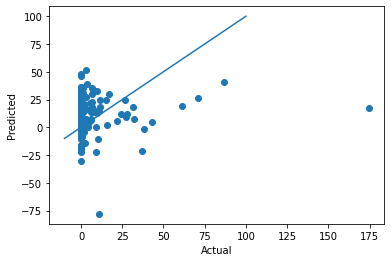

In [88]:
clf=SGDRegressor().fit(x_train,y_train)
print("RMSE : ",np.mean((clf.predict(x_test)-y_test)**2))
plt.scatter(y_test,clf.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

RMSE :  480.1093699763939


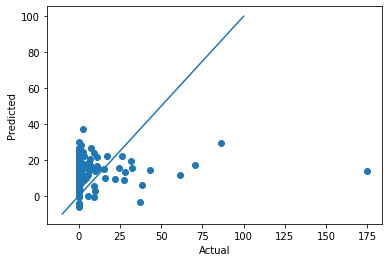

In [89]:
clf=ElasticNet().fit(x_train,y_train)
print("RMSE : ",np.mean((clf.predict(x_test)-y_test)**2))
plt.scatter(y_test,clf.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

RMSE :  441.61263439041585


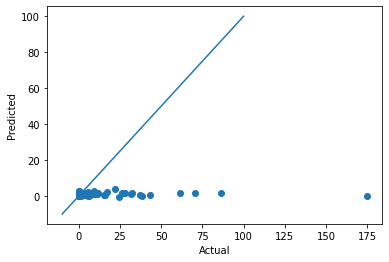

In [90]:
clf=SVR().fit(x_train,y_train)
print("RMSE : ",np.mean((clf.predict(x_test)-y_test)**2))
plt.scatter(y_test,clf.predict(x_test))
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.plot([-10,100],[-10,100])

# Support Vector regressor was the best performing model in terms of root mean square error